## Repères du notebook 
    
   1. [Introduction: observation des données](#introduction)
   

   2. [modèles considérées: validation croisée des hyper-paramètres](#p1)
   
       [train-test split et preprocessor](#split)
       
       [Modèle 0: regression linéaire, sans cross validation](#m0)
       
       [Modèle 1: knn regressor , gridsearchCV](#m1)
       
       [Modèle 2: random forest regressor , gridsearchCV](#m2)
       
       [Modèle 3: XGboost , RandomizedsearchCV](#m3)
       
       [Modele 4: Elasticnet, gridsearchCV](#m4)
       
   
   3. [Comparaison des modèles](#res)
   
   
   4. [Modèle choisi RandomForest: comparaison avec et sans "Energystarscore"](#p3)
   
       [avec energy star score](#p4)
       
       [sans energy star score](#p5)
       
       
   5. [Conclusion: tableaux récapitulatifs des résultats](#ccl)
   
   
   

## Corrections post-soutenance:

   1. [Correction 1 "Listofallpropertyuse": Problème Encodage -> drop ](#corr1)
   
   
   2. [Correction 2: "GHGEmissionsIntensity" et fuite des données -> drop](#corr2)
   
   
   3. [Correction 3: Nouveau meilleur modèle: RandomForest](#corr3)
   
    
    


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import missingno as msno
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.impute import KNNImputer
import statsmodels.formula.api
import statsmodels.api
import time
import dataframe_image as dfi
import scipy.stats as stats

plt.style.use('seaborn-whitegrid')
#options d'affichage
pd.set_option('display.max_row', 200)
pd.set_option('display.max_column', 70)

## 1. Introduction: observation des données <a class="anchor" id="introduction"></a>

In [2]:
data = pd.read_pickle("cleaned_data")

In [3]:
data.head()

,BuildingType,PrimaryPropertyType,Latitude,Longitude,ListOfAllPropertyUseTypes,LargestPropertyUseType,ComplianceStatus,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SiteEnergyUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ENERGYSTARScore,BuildingAge
0,NonResidential,Retail Store,47.611711,-122.336816,NaN,NaN,Compliant,1.0,4.0,111077.0,0.0,16.107916,4.234251,0.24,91.0,26
1,NonResidential,Small- and Mid-Sized Office,47.606799,-122.337100,Office,Office,Compliant,1.0,6.0,98370.0,25920.0,15.691287,3.855241,0.20,45.0,109
2,NonResidential,Large Office,47.621476,-122.343050,"Data Center, Office, Other, Parking, Restaurant",Office,Compliant,1.0,4.0,193788.0,37854.0,16.634519,4.760805,0.23,59.0,68
3,NonResidential,Small- and Mid-Sized Office,47.570897,-122.297412,"Office, Parking",Office,Compliant,1.0,3.0,76598.0,21410.0,15.314463,4.902976,1.63,76.0,7
4,NonResidential,Large Office,47.621243,-122.329786,"Office, Parking",Office,Compliant,1.0,4.0,186971.0,0.0,16.354152,5.424598,0.99,86.0,34


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1662 entries, 0 to 1697
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1662 non-null   object 
 1   PrimaryPropertyType        1662 non-null   object 
 2   Latitude                   1662 non-null   float64
 3   Longitude                  1662 non-null   float64
 4   ListOfAllPropertyUseTypes  1655 non-null   object 
 5   LargestPropertyUseType     1651 non-null   object 
 6   ComplianceStatus           1662 non-null   object 
 7   NumberofBuildings          1662 non-null   float64
 8   NumberofFloors             1662 non-null   float64
 9   PropertyGFATotal           1662 non-null   float64
 10  PropertyGFAParking         1662 non-null   float64
 11  SiteEnergyUse(kBtu)        1662 non-null   float64
 12  TotalGHGEmissions          1662 non-null   float64
 13  GHGEmissionsIntensity      1662 non-null   float

# Correction 1: <a class="anchor" id="corr1"></a>

In [5]:
#complète les valeurs manquantes pour nos modèles
data['LargestPropertyUseType'] = data['LargestPropertyUseType'].fillna("Miss")
data['ListOfAllPropertyUseTypes'] = data['ListOfAllPropertyUseTypes'].fillna("Miss")

#correction: list pas adapter à encodage (targetencoder) et information déja disponible dans autres variables.
data.drop('ListOfAllPropertyUseTypes', axis=1, inplace = True)
data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Latitude', 'Longitude',
       'LargestPropertyUseType', 'ComplianceStatus', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'ENERGYSTARScore', 'BuildingAge'],
      dtype='object')

In [6]:
data.describe()

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SiteEnergyUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ENERGYSTARScore,BuildingAge
count,1662.000000,1662.000000,1662.000000,1662.000000,1.662000e+03,1662.000000,1662.000000,1662.000000,1662.000000,1135.000000,1662.000000
mean,47.616151,-122.333033,1.056558,4.073406,1.073845e+05,13339.205475,14.901546,3.938783,1.450205,64.903084,54.071600
std,0.048144,0.024538,0.712486,6.490536,1.761349e+05,42261.055870,1.218225,1.399869,2.053595,27.969873,32.832291
min,47.499170,-122.411820,0.500000,0.000000,1.128500e+04,-1.000000,11.523130,0.053541,0.010000,1.000000,1.000000
25%,47.585485,-122.343395,1.000000,1.000000,2.939550e+04,0.000000,14.030261,3.020120,0.280000,46.750000,27.000000
50%,47.612480,-122.333015,1.000000,2.000000,4.905900e+04,0.000000,14.753962,3.917358,0.787500,72.500000,51.000000
75%,47.649577,-122.321770,1.000000,4.000000,1.038575e+05,0.000000,15.723156,4.915509,1.740000,88.000000,86.000000
max,47.733870,-122.258640,15.000000,99.000000,1.952220e+06,512608.000000,18.356130,7.637900,23.405000,100.000000,116.000000


In [7]:
data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Latitude', 'Longitude',
       'LargestPropertyUseType', 'ComplianceStatus', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'ENERGYSTARScore', 'BuildingAge'],
      dtype='object')

# Correction 2:<a class="anchor" id="corr2"></a>

In [8]:
#Correction: fuite des données: GHGEmissionsIntensity implique de connaitre TotalGHGEmissions/
#se calcul à partir des mêmes informations,
#de l'information non-contenu dans les données d'entrainement qui servent à la prédiction de la variable.
print(data.corr())
data.drop('GHGEmissionsIntensity', axis=1, inplace = True)

                       Latitude  Longitude  NumberofBuildings  NumberofFloors  \
Latitude               1.000000  -0.101548          -0.021183       -0.010749   
Longitude             -0.101548   1.000000           0.020459       -0.013430   
NumberofBuildings     -0.021183   0.020459           1.000000       -0.033576   
NumberofFloors        -0.010749  -0.013430          -0.033576        1.000000   
PropertyGFATotal      -0.018328  -0.007470           0.097204        0.684308   
PropertyGFAParking     0.033909  -0.028218           0.003079        0.518555   
SiteEnergyUse(kBtu)    0.044115  -0.006484           0.132879        0.424068   
TotalGHGEmissions      0.048471   0.006991           0.117168        0.296563   
GHGEmissionsIntensity  0.058618  -0.004943           0.012808       -0.070094   
ENERGYSTARScore        0.051534  -0.006602          -0.032678        0.121842   
BuildingAge           -0.066457  -0.018766          -0.029552       -0.091923   

                       Prop

In [9]:
#on exclut energy star score pour le moment:
energystar_score = data['ENERGYSTARScore']
data = data.drop(['ENERGYSTARScore'], axis=1)

In [10]:
num_data = data.select_dtypes(include=['int64','float64'])
cat_data = data.select_dtypes(exclude=['int64','float64']) 

In [11]:
cat_data.nunique()

BuildingType               5
PrimaryPropertyType       24
LargestPropertyUseType    58
ComplianceStatus           4
dtype: int64

In [12]:
cat_data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',
       'ComplianceStatus'],
      dtype='object')

In [13]:
num_data.columns

Index(['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'BuildingAge'],
      dtype='object')

## 2. modèles considérées: validation croisée des hyper-paramètres <a class="anchor" id="p1"></a>

## train-test split et preprocessor de Pipeline <a class="anchor" id="split"></a>

In [14]:
%%time
from sklearn.model_selection import train_test_split

X = data.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)
Y = data[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

print(X_train.shape[0], X_test.shape[0])

1329 333
Wall time: 1.99 ms


In [15]:
%%time
from sklearn.preprocessing import StandardScaler, RobustScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer

target_features = ['BuildingType', 'PrimaryPropertyType',
       'LargestPropertyUseType', 'ComplianceStatus']
target_transformer = TargetEncoder()

numeric_features = ['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'BuildingAge']
numeric_transformer = RobustScaler(unit_variance=True)

preprocessor = ColumnTransformer(transformers=[
    ('target', target_transformer, target_features),
    ('numeric', numeric_transformer, numeric_features)
])

Wall time: 16.9 ms


## Modèle 0: regression linéaire, sans cross validation<a class="anchor" id="m0"></a>

In [16]:
import sklearn
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator


%matplotlib inline

In [17]:
xtrain = X_train[['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'BuildingAge']]
xtest = X_test[['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'BuildingAge']]
ytrain = Y_train
ytest = Y_test

In [18]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(xtrain)
xtrain_scaled = std_scale.transform(xtrain)

In [19]:
# attention scale:std_scale = preprocessing.StandardScaler().fit(xtest) modifie la standardisation. utiliser directement:
xtest = std_scale.transform(xtest)

In [20]:
%%time
#regr lineaire classique pour "baseline":
from sklearn import linear_model
from sklearn import metrics

#modele de regression lineaire
m0_lr = linear_model.LinearRegression(fit_intercept = True)

#on fit à nos données d'entrainement et on conserve le temps d'execution:
start = time.time()
m0_lr_SEU = m0_lr.fit(xtrain,ytrain['SiteEnergyUse(kBtu)'])
m0_lr_TGE = m0_lr.fit(xtrain,ytrain['TotalGHGEmissions'])
end = time.time()
time_fit_m0 = end - start
print(time_fit_m0)


0.019015789031982422
Wall time: 19 ms


In [21]:
%%time
ypred_SEU = m0_lr_SEU.predict(xtest)
ypred_TGE = m0_lr_TGE.predict(xtest)

#fonction pour comparer et stocker les résultats:
def Comp_metrics(xtest, ytest, ypred):
    mse = sklearn.metrics.mean_squared_error(ytest, ypred)
    rmse = math.sqrt(mse)
    R2 = metrics.r2_score(ytest, ypred)
    MAE = metrics.mean_absolute_error(ytest, ypred)
    print('MSE :', mse , 'RMSE :', rmse, 'R2 :', R2, 'MAE :', MAE)
    
    results = {'Name_metrics':['MSE', 'RMSE', 'R2', 'MAE'],
        'result':[mse, rmse, R2, MAE]}
 
    # Create DataFrame
    df = pd.DataFrame(results)

    return df

Wall time: 997 µs


In [22]:
%%time
m0_res_SEU = Comp_metrics(xtest, ytest['SiteEnergyUse(kBtu)'], ypred_SEU )

MSE : 786.1352667224169 RMSE : 28.038103836073095 R2 : -535.0615109553489 MAE : 27.927118541586875
Wall time: 997 µs


In [23]:
%%time
m0_res_TGE = Comp_metrics(xtest, ytest['TotalGHGEmissions'], ypred_TGE )

MSE : 294.172936292278 RMSE : 17.151470382806192 R2 : -150.91334681027087 MAE : 16.9607946841592
Wall time: 997 µs


In [24]:
%%time
print(m0_res_TGE)
print('----------------')
print(m0_res_SEU)




  Name_metrics      result
0          MSE  294.172936
1         RMSE   17.151470
2           R2 -150.913347
3          MAE   16.960795
----------------
  Name_metrics      result
0          MSE  786.135267
1         RMSE   28.038104
2           R2 -535.061511
3          MAE   27.927119
Wall time: 2.99 ms


## Modèle 1: knn regressor , gridsearchCV<a class="anchor" id="m1"></a>

In [25]:
%%time
#méthode "gridsearchcv" pour validation croisée du parametre k d'un knn:
from sklearn import neighbors, metrics, model_selection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

mlr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_mlr', GridSearchCV(neighbors.KNeighborsRegressor(), 
                            param_grid={'n_neighbors':[1,3,5,7,9,11,13,15,17, 20, 35, 50]},
                            cv=5,
                            scoring='neg_mean_absolute_error',
                            return_train_score = True))])

Wall time: 0 ns


In [26]:
%%time
#on entraine notre regresseur sur le jeu d'entrainement:
start = time.time()
m1_knn_SEU = mlr_grid_cv.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
m1_knn_TGE = mlr_grid_cv.fit(X_train,Y_train['TotalGHGEmissions'])
end = time.time()
time_fit_m1 = end - start
print(time_fit_m1)

#Afficher les hyper param optimaux (les k):
print("Meilleurs hyperparametres sur le training set:")
print("SEU :", m1_knn_SEU['grid_search_mlr'].best_params_)
print("------------------")
print("TGE :", m1_knn_TGE['grid_search_mlr'].best_params_)
print("------------------")


2.353996992111206
Meilleurs hyperparametres sur le training set:
SEU : {'n_neighbors': 20}
------------------
TGE : {'n_neighbors': 20}
------------------
Wall time: 2.35 s


In [27]:
%%time
ypred_SEU = m1_knn_SEU.predict(X_test)
ypred_TGE = m1_knn_TGE.predict(X_test)

Wall time: 29.9 ms


In [28]:
%%time
m1_res_SEU = Comp_metrics(X_test, Y_test['SiteEnergyUse(kBtu)'], ypred_SEU )
print("------------------")
m1_res_TGE = Comp_metrics(X_test, Y_test['TotalGHGEmissions'], ypred_TGE )

MSE : 123.67563342126688 RMSE : 11.12095469918239 R2 : -83.33376509945306 MAE : 11.090773452131675
------------------
MSE : 1.3002035881864071 RMSE : 1.1402647009297477 R2 : 0.3285640715097111 MAE : 0.9106602735895851
Wall time: 2.97 ms


## Modèle 2: random forest regressor , gridsearchCV<a class="anchor" id="m2"></a>

In [29]:
%%time
from sklearn.ensemble import RandomForestRegressor

#fixer les valeurs des hyperpara à tester:
param_rfr = {"n_estimators": [1, 10, 25, 50, 75, 100],
             'max_depth': [5, 15, 25, 50],
             'min_samples_split': [2, 5, 10],
             'bootstrap' : [True, False],
             'min_samples_leaf': [1,2,5,10]}

mlr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_mlr', GridSearchCV(RandomForestRegressor(), 
                            param_grid = param_rfr,
                            cv=5,
                            scoring='neg_mean_absolute_error',
                            return_train_score = True))])

Wall time: 25 ms


In [30]:
%%time
#sur le jeu d'entrainement:
start = time.time()
m2_rfr_SEU = mlr_grid_cv.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
m2_rfr_TGE = mlr_grid_cv.fit(X_train,Y_train['TotalGHGEmissions'])
end = time.time()
time_fit_m2 = end - start
print(time_fit_m2)


716.679327249527
Wall time: 11min 56s


In [31]:
#Afficher les hyper param optimaux:
print("Meilleurs hyperparametres sur le training set:")
print("SEU :", m2_rfr_SEU['grid_search_mlr'].best_params_)
print("------------------")
print("TGE :", m2_rfr_TGE['grid_search_mlr'].best_params_)
print("------------------")


Meilleurs hyperparametres sur le training set:
SEU : {'bootstrap': True, 'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
------------------
TGE : {'bootstrap': True, 'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
------------------


In [32]:
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [33]:
%%time
ypred_SEU = m2_rfr_SEU.predict(X_test)
ypred_TGE = m2_rfr_TGE.predict(X_test)

m2_res_SEU = Comp_metrics(X_test, Y_test['SiteEnergyUse(kBtu)'], ypred_SEU )
print("------------------")
m2_res_TGE = Comp_metrics(X_test, Y_test['TotalGHGEmissions'], ypred_TGE )

MSE : 122.42067941842801 RMSE : 11.064387891719452 R2 : -82.478018553765 MAE : 11.042435676194657
------------------
MSE : 0.9717402920995508 RMSE : 0.9857688837144084 R2 : 0.49818524482971616 MAE : 0.787092314337241
Wall time: 15.6 ms


## Modèle 3: XGboost , RandomizedsearchCV<a class="anchor" id="m3"></a>

In [34]:
%%time
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

#fixer les valeurs des hyperpara à tester:
param_xgb = {'learning_rate' : [0.001, 0.01, 0.1, 0.15, 0.2],
             'gamma': [0, 0.25, 0.5, 1.0],
             'max_depth': [10, 15, 20, 25],
             'n_estimators': [25, 35, 50, 75, 100]}

mlr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_mlr', RandomizedSearchCV(xgb.XGBRegressor(tree_method='gpu_hist'), 
                            param_distributions=param_xgb,
                            n_iter=20,
                            cv=5,  #nombre de folds de validation croisée
    scoring = 'neg_mean_absolute_error', #score à optimiser
    return_train_score = True))])

Wall time: 15.7 ms


In [35]:
%%time
#sur le jeu d'entrainement:
start = time.time()
m3_xgb_SEU = mlr_grid_cv.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
m3_xgb_TGE = mlr_grid_cv.fit(X_train,Y_train['TotalGHGEmissions'])
end = time.time()
time_fit_m3 = end - start
print(time_fit_m3)

#Afficher les hyper param optimaux:
print("Meilleurs hyperparametres sur le training set:")
print("SEU :", m3_xgb_SEU['grid_search_mlr'].best_params_)
print("------------------")
print("TGE :", m3_xgb_TGE['grid_search_mlr'].best_params_)
print("------------------")


335.1861398220062
Meilleurs hyperparametres sur le training set:
SEU : {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 1.0}
------------------
TGE : {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 1.0}
------------------
Wall time: 5min 35s


In [36]:
%%time
ypred_SEU = m3_xgb_SEU.predict(X_test)
ypred_TGE = m3_xgb_TGE.predict(X_test)

Wall time: 20.9 ms


In [37]:
m3_res_SEU = Comp_metrics(X_test, Y_test['SiteEnergyUse(kBtu)'], ypred_SEU )
print("------------------")
m3_res_TGE = Comp_metrics(X_test, Y_test['TotalGHGEmissions'], ypred_TGE )

MSE : 123.10955394784665 RMSE : 11.095474480518922 R2 : -82.94775847859806 MAE : 11.072543802799165
------------------
MSE : 1.0191832922695374 RMSE : 1.0095460822912135 R2 : 0.47368528562414836 MAE : 0.8091882495148206


## Modele 4: Elasticnet, gridsearchCV <a class="anchor" id="m4"></a>

In [38]:
%%time
from sklearn.linear_model import ElasticNet

param_eNet = {"max_iter": [5, 10, 20, 30, 50, 100, 500],
              "alpha": np.logspace(-4, 0, num=5),
              "l1_ratio": np.arange(0.0, 1.1, 0.1)}

mlr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_mlr', GridSearchCV( ElasticNet(),
                        param_grid=param_eNet,
                        cv=5,
                        scoring='neg_mean_absolute_error',
                        return_train_score = True))])


Wall time: 0 ns


In [39]:
%%time
#Warnings de convergence: certaines iter ne convergent pas. python propose de les augmenter.
import warnings
warnings.filterwarnings('ignore')
#sur le jeu d'entrainement:
start = time.time()
m4_Enet_SEU = mlr_grid_cv.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
m4_Enet_TGE = mlr_grid_cv.fit(X_train,Y_train['TotalGHGEmissions'])
end = time.time()
time_fit_m4 = end - start
print(time_fit_m4)

#Afficher les hyper param optimaux:
print("Meilleurs hyperparametres sur le training set:")
print("SEU :", m4_Enet_SEU['grid_search_mlr'].best_params_)
print("------------------")
print("TGE :", m4_Enet_TGE['grid_search_mlr'].best_params_)
print("------------------")


6.770902395248413
Meilleurs hyperparametres sur le training set:
SEU : {'alpha': 0.001, 'l1_ratio': 1.0, 'max_iter': 20}
------------------
TGE : {'alpha': 0.001, 'l1_ratio': 1.0, 'max_iter': 20}
------------------
Wall time: 6.77 s


In [40]:
%%time
ypred_SEU = m4_Enet_SEU.predict(X_test)
ypred_TGE = m4_Enet_TGE.predict(X_test)

m4_res_SEU = Comp_metrics(X_test, Y_test['SiteEnergyUse(kBtu)'], ypred_SEU )
print("------------------")
m4_res_TGE = Comp_metrics(X_test, Y_test['TotalGHGEmissions'], ypred_TGE )

MSE : 121.74427363068605 RMSE : 11.033778755743024 R2 : -82.01678099841699 MAE : 11.003801903938847
------------------
MSE : 1.118601784278837 RMSE : 1.057639723289002 R2 : 0.4223447508818322 MAE : 0.8419330220514959
Wall time: 81.8 ms


## 3. Comparaison des modèles<a class="anchor" id="res"></a>

In [41]:
for i in range(0,5):
    print('---------------------')
    print('metrics for SiteEnergyUse(kBtu) predictions on test data, model {} : \n'.format(i) )
    print(eval('m{}_res_SEU'.format(i)))
    

---------------------
metrics for SiteEnergyUse(kBtu) predictions on test data, model 0 : 

  Name_metrics      result
0          MSE  786.135267
1         RMSE   28.038104
2           R2 -535.061511
3          MAE   27.927119
---------------------
metrics for SiteEnergyUse(kBtu) predictions on test data, model 1 : 

  Name_metrics      result
0          MSE  123.675633
1         RMSE   11.120955
2           R2  -83.333765
3          MAE   11.090773
---------------------
metrics for SiteEnergyUse(kBtu) predictions on test data, model 2 : 

  Name_metrics      result
0          MSE  122.420679
1         RMSE   11.064388
2           R2  -82.478019
3          MAE   11.042436
---------------------
metrics for SiteEnergyUse(kBtu) predictions on test data, model 3 : 

  Name_metrics      result
0          MSE  123.109554
1         RMSE   11.095474
2           R2  -82.947758
3          MAE   11.072544
---------------------
metrics for SiteEnergyUse(kBtu) predictions on test data, model 4 : 



In [42]:
for i in range(0,5):
    print('---------------------')
    print('metrics for TotalGHGEmissions predictions on test data, model {} : \n'.format(i) )
    print(eval('m{}_res_TGE'.format(i)))
    

---------------------
metrics for TotalGHGEmissions predictions on test data, model 0 : 

  Name_metrics      result
0          MSE  294.172936
1         RMSE   17.151470
2           R2 -150.913347
3          MAE   16.960795
---------------------
metrics for TotalGHGEmissions predictions on test data, model 1 : 

  Name_metrics    result
0          MSE  1.300204
1         RMSE  1.140265
2           R2  0.328564
3          MAE  0.910660
---------------------
metrics for TotalGHGEmissions predictions on test data, model 2 : 

  Name_metrics    result
0          MSE  0.971740
1         RMSE  0.985769
2           R2  0.498185
3          MAE  0.787092
---------------------
metrics for TotalGHGEmissions predictions on test data, model 3 : 

  Name_metrics    result
0          MSE  1.019183
1         RMSE  1.009546
2           R2  0.473685
3          MAE  0.809188
---------------------
metrics for TotalGHGEmissions predictions on test data, model 4 : 

  Name_metrics    result
0          MSE 

In [43]:
runtimes_fit = [eval('time_fit_m{}'.format(i)) for i in range(0,5)]
# Calling DataFrame constructor on list
# with indices and columns specified
df = pd.DataFrame(runtimes_fit, index =['m{}'.format(i) for i in range(0,5)],
                                              columns =['fit runtimes'])
dfi.export(df, 'temps_fit_modeles.png')
df

,fit runtimes
m0,0.019016
m1,2.353997
m2,716.679327
m3,335.186140
m4,6.770902


# Correction 3:<a class="anchor" id="corr3"></a>

## 4. Modèle final RandomForest: comparaison avec et sans "Energystarscore"<a class="anchor" id="p3"></a>

In [44]:
data['ENERGYSTARScore'] = energystar_score
data.head()

,BuildingType,PrimaryPropertyType,Latitude,Longitude,LargestPropertyUseType,ComplianceStatus,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildingAge,ENERGYSTARScore
0,NonResidential,Retail Store,47.611711,-122.336816,Miss,Compliant,1.0,4.0,111077.0,0.0,16.107916,4.234251,26,91.0
1,NonResidential,Small- and Mid-Sized Office,47.606799,-122.337100,Office,Compliant,1.0,6.0,98370.0,25920.0,15.691287,3.855241,109,45.0
2,NonResidential,Large Office,47.621476,-122.343050,Office,Compliant,1.0,4.0,193788.0,37854.0,16.634519,4.760805,68,59.0
3,NonResidential,Small- and Mid-Sized Office,47.570897,-122.297412,Office,Compliant,1.0,3.0,76598.0,21410.0,15.314463,4.902976,7,76.0
4,NonResidential,Large Office,47.621243,-122.329786,Office,Compliant,1.0,4.0,186971.0,0.0,16.354152,5.424598,34,86.0


In [45]:
data_sans = data[data['ENERGYSTARScore'].isna()]
data_sans.shape

(527, 14)

In [46]:
data_avec = data[data['ENERGYSTARScore'].notna()]
data_avec.shape

(1135, 14)

## avec energy star score<a class="anchor" id="p4"></a>

In [47]:
%%time
from sklearn.model_selection import train_test_split

X = data_avec.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)
Y = data_avec[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

print(X_train.shape[0], X_test.shape[0])

908 227
Wall time: 2.02 ms


In [48]:
data_avec['ENERGYSTARScore'].describe()

count    1135.000000
mean       64.903084
std        27.969873
min         1.000000
25%        46.750000
50%        72.500000
75%        88.000000
max       100.000000
Name: ENERGYSTARScore, dtype: float64

<AxesSubplot:>

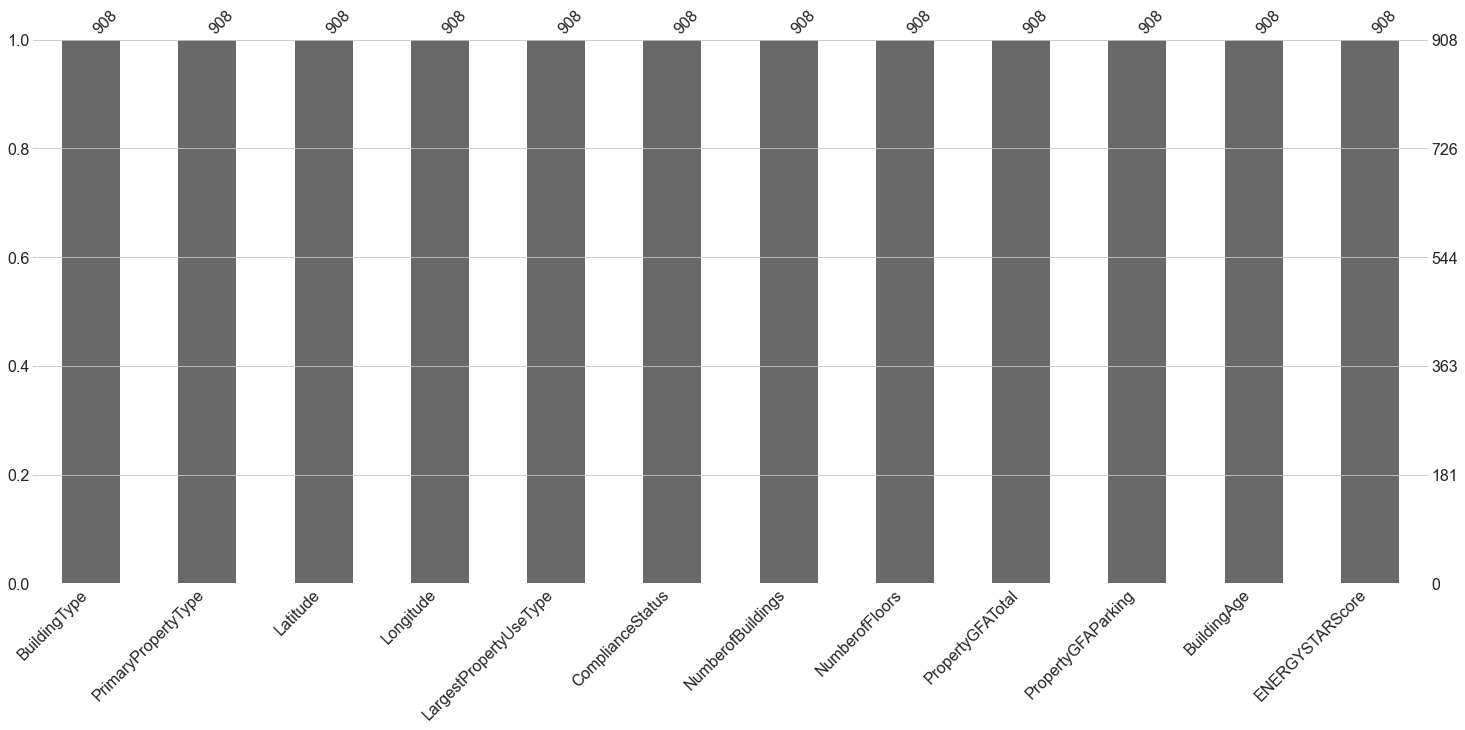

In [49]:
msno.bar(X_train)

In [50]:
%%time
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, RobustScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer

target_features = ['BuildingType', 'PrimaryPropertyType',
       'LargestPropertyUseType', 'ComplianceStatus']
target_transformer = TargetEncoder()

numeric_features = ['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'BuildingAge', 'ENERGYSTARScore']
numeric_transformer = RobustScaler(unit_variance=True)

preprocessor = ColumnTransformer(transformers=[
    ('target', target_transformer, target_features),
    ('numeric', numeric_transformer, numeric_features)
])

Wall time: 0 ns


In [51]:
%%time
from sklearn.ensemble import RandomForestRegressor

#fixer les valeurs des hyperpara à tester:
param_rfr = {"n_estimators": [1, 10, 25, 50, 75, 100],
             'max_depth': [5, 15, 25, 50],
             'min_samples_split': [2, 5, 10],
             'bootstrap' : [True, False],
             'min_samples_leaf': [1,2,5,10]}

mlr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_mlr', GridSearchCV(RandomForestRegressor(), 
                            param_grid = param_rfr,
                            cv=5,
                            scoring='neg_mean_absolute_error',
                            return_train_score = True))])

Wall time: 0 ns


In [52]:
%%time
#entrainement:
mfavec_rfr_SEU = mlr_grid_cv.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
mfavec_rfr_TGE = mlr_grid_cv.fit(X_train,Y_train['TotalGHGEmissions'])

#Afficher les hyper param optimaux:
print("Meilleurs hyperparametres sur le training set:")
print("SEU :", mfavec_rfr_SEU['grid_search_mlr'].best_params_)
print("------------------")
print("TGE :", mfavec_rfr_TGE['grid_search_mlr'].best_params_)
print("------------------")


Meilleurs hyperparametres sur le training set:
SEU : {'bootstrap': True, 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
------------------
TGE : {'bootstrap': True, 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
------------------
Wall time: 9min 48s


In [53]:
%%time
ypred_SEU = mfavec_rfr_SEU.predict(X_test)
ypred_TGE = mfavec_rfr_TGE.predict(X_test)

Wall time: 32.9 ms


In [54]:
mfavec_res_SEU = Comp_metrics(X_test, Y_test['SiteEnergyUse(kBtu)'], ypred_SEU )
print("------------------")
mfavec_res_TGE = Comp_metrics(X_test, Y_test['TotalGHGEmissions'], ypred_TGE )

MSE : 121.53296520629986 RMSE : 11.024199073234294 R2 : -89.97759295436376 MAE : 11.004750237987054
------------------
MSE : 0.9521656539853464 RMSE : 0.9757897591107145 R2 : 0.5197410090763408 MAE : 0.7467370895944531


## sans energy star score<a class="anchor" id="p5"></a>

In [55]:
%%time
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, RobustScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer

target_features = ['BuildingType', 'PrimaryPropertyType',
       'LargestPropertyUseType', 'ComplianceStatus']
target_transformer = TargetEncoder()

numeric_features = ['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'BuildingAge']
numeric_transformer = RobustScaler(unit_variance=True)

preprocessor = ColumnTransformer(transformers=[
    ('target', target_transformer, target_features),
    ('numeric', numeric_transformer, numeric_features)
])

Wall time: 0 ns


In [56]:
%%time
from sklearn.ensemble import RandomForestRegressor

#fixer les valeurs des hyperpara à tester:
param_rfr = {"n_estimators": [1, 10, 25, 50, 75, 100],
             'max_depth': [5, 15, 25, 50],
             'min_samples_split': [2, 5, 10],
             'bootstrap' : [True, False],
             'min_samples_leaf': [1,2,5,10]}

mlr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_mlr', GridSearchCV(RandomForestRegressor(), 
                            param_grid = param_rfr,
                            cv=5,
                            scoring='neg_mean_absolute_error',
                            return_train_score = True))])

Wall time: 0 ns


In [57]:
%%time
#entrainement:
mfsans_rfr_SEU = mlr_grid_cv.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
mfsans_rfr_TGE = mlr_grid_cv.fit(X_train,Y_train['TotalGHGEmissions'])

#Afficher les hyper param optimaux:
print("Meilleurs hyperparametres sur le training set:")
print("SEU :", mfsans_rfr_SEU['grid_search_mlr'].best_params_)
print("------------------")
print("TGE :", mfsans_rfr_TGE['grid_search_mlr'].best_params_)
print("------------------")


Meilleurs hyperparametres sur le training set:
SEU : {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
------------------
TGE : {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
------------------
Wall time: 8min 59s


In [58]:
ypred_SEU = mfsans_rfr_SEU.predict(X_test)
ypred_TGE = mfsans_rfr_TGE.predict(X_test)

In [59]:
mfsans_res_SEU = Comp_metrics(X_test, Y_test['SiteEnergyUse(kBtu)'], ypred_SEU )
print("------------------")
mfsans_res_TGE = Comp_metrics(X_test, Y_test['TotalGHGEmissions'], ypred_TGE )

MSE : 121.18259831316979 RMSE : 11.008296794380582 R2 : -89.71531402013579 MAE : 10.983385345676151
------------------
MSE : 1.0157785180238768 RMSE : 1.00785838192867 R2 : 0.4876555733488106 MAE : 0.7660548539029857


In [60]:
for i in range(0,5):
    print('---------------------')
    print('metrics for TotalGHGEmissions predictions on test data, model {} : \n'.format(i) )
    print(eval('m{}_res_TGE'.format(i)))

---------------------
metrics for TotalGHGEmissions predictions on test data, model 0 : 

  Name_metrics      result
0          MSE  294.172936
1         RMSE   17.151470
2           R2 -150.913347
3          MAE   16.960795
---------------------
metrics for TotalGHGEmissions predictions on test data, model 1 : 

  Name_metrics    result
0          MSE  1.300204
1         RMSE  1.140265
2           R2  0.328564
3          MAE  0.910660
---------------------
metrics for TotalGHGEmissions predictions on test data, model 2 : 

  Name_metrics    result
0          MSE  0.971740
1         RMSE  0.985769
2           R2  0.498185
3          MAE  0.787092
---------------------
metrics for TotalGHGEmissions predictions on test data, model 3 : 

  Name_metrics    result
0          MSE  1.019183
1         RMSE  1.009546
2           R2  0.473685
3          MAE  0.809188
---------------------
metrics for TotalGHGEmissions predictions on test data, model 4 : 

  Name_metrics    result
0          MSE 

In [61]:
mfsans_res_SEU['result']

0    121.182598
1     11.008297
2    -89.715314
3     10.983385
Name: result, dtype: float64

## 5. Conclusion: tableaux récapitulatifs des résultats<a class="anchor" id="ccl"></a>

In [62]:
results_SEU = pd.concat([m0_res_SEU['Name_metrics'], m0_res_SEU['result'], m1_res_SEU['result'], m2_res_SEU['result'], m3_res_SEU['result'], m4_res_SEU['result'],
                    mfsans_res_SEU['result'],
                    mfavec_res_SEU['result']], axis = 1, keys = ['Name_metrics', "m0","m1","m2","m3","m4", "mfSANS", "mfAVEC"] )

dfi.export(results_SEU, 'resultats_SiteEnergyUse_table.png')
results_SEU


,Name_metrics,m0,m1,m2,m3,m4,mfSANS,mfAVEC
0,MSE,786.135267,123.675633,122.420679,123.109554,121.744274,121.182598,121.532965
1,RMSE,28.038104,11.120955,11.064388,11.095474,11.033779,11.008297,11.024199
2,R2,-535.061511,-83.333765,-82.478019,-82.947758,-82.016781,-89.715314,-89.977593
3,MAE,27.927119,11.090773,11.042436,11.072544,11.003802,10.983385,11.004750


In [63]:
results_TGE = pd.concat([m0_res_TGE['Name_metrics'], m0_res_TGE['result'], m1_res_TGE['result'], m2_res_TGE['result'], m3_res_TGE['result'], m4_res_TGE['result'],
                    mfsans_res_TGE['result'],
                    mfavec_res_TGE['result']], axis = 1, keys = ['Name_metrics', "m0","m1","m2","m3","m4", "mfSANS", "mfAVEC"] )

dfi.export(results_TGE, 'resultats_TotalGHGEmissions_table.png')
results_TGE

,Name_metrics,m0,m1,m2,m3,m4,mfSANS,mfAVEC
0,MSE,294.172936,1.300204,0.971740,1.019183,1.118602,1.015779,0.952166
1,RMSE,17.151470,1.140265,0.985769,1.009546,1.057640,1.007858,0.975790
2,R2,-150.913347,0.328564,0.498185,0.473685,0.422345,0.487656,0.519741
3,MAE,16.960795,0.910660,0.787092,0.809188,0.841933,0.766055,0.746737
